# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217393

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e4 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})

            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-3]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.481972 | Test Loss: 1.654404 | Test Accuracy: 0.776038
Step 2 | Training Loss: 0.412455 | Test Loss: 1.623504 | Test Accuracy: 0.786418
Step 3 | Training Loss: 0.558631 | Test Loss: 1.571696 | Test Accuracy: 0.769163
Step 4 | Training Loss: 0.312605 | Test Loss: 1.555411 | Test Accuracy: 0.774175
Step 5 | Training Loss: 0.268642 | Test Loss: 1.559218 | Test Accuracy: 0.768320
Step 6 | Training Loss: 0.379598 | Test Loss: 1.548346 | Test Accuracy: 0.747516
Step 7 | Training Loss: 0.478799 | Test Loss: 1.606665 | Test Accuracy: 0.743568
Step 8 | Training Loss: 0.372302 | Test Loss: 1.617922 | Test Accuracy: 0.782958
Step 9 | Training Loss: 0.443690 | Test Loss: 1.717000 | Test Accuracy: 0.746008
Step 10 | Training Loss: 0.337674 | Test Loss: 1.705379 | Test Accuracy: 0.741217
Step 11 | Training Loss: 0.457081 | Test Loss: 1.695695 | Test Accuracy: 0.743524
Step 12 | Training Loss: 0.487694 | T

Step 1 | Training Loss: 0.103980 | Test Loss: 1.136332 | Test Accuracy: 0.749690
Step 2 | Training Loss: 0.093911 | Test Loss: 1.131129 | Test Accuracy: 0.747339
Step 3 | Training Loss: 0.098961 | Test Loss: 1.130095 | Test Accuracy: 0.747028
Step 4 | Training Loss: 0.139890 | Test Loss: 1.125268 | Test Accuracy: 0.745742
Step 5 | Training Loss: 0.163700 | Test Loss: 1.121491 | Test Accuracy: 0.746718
Step 6 | Training Loss: 0.155027 | Test Loss: 1.117130 | Test Accuracy: 0.747738
Step 7 | Training Loss: 0.219287 | Test Loss: 1.115047 | Test Accuracy: 0.747605
Step 8 | Training Loss: 0.100337 | Test Loss: 1.115280 | Test Accuracy: 0.748492
Step 9 | Training Loss: 0.092998 | Test Loss: 1.112476 | Test Accuracy: 0.749246
Step 10 | Training Loss: 0.357822 | Test Loss: 1.110947 | Test Accuracy: 0.749335
Step 11 | Training Loss: 0.298841 | Test Loss: 1.109263 | Test Accuracy: 0.749512
Step 12 | Training Loss: 0.146405 | Test Loss: 1.113067 | Test Accuracy: 0.751242
Step 13 | Training Loss: 

Step 2 | Training Loss: 0.378008 | Test Loss: 1.462216 | Test Accuracy: 0.753149
Step 3 | Training Loss: 0.406645 | Test Loss: 1.570901 | Test Accuracy: 0.761222
Step 4 | High Training Loss: 111914408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_nsl_kdd/hidden layers_30_features count_2/model-1
Step 4 | Training Loss: 0.422183 | Test Loss: 1.593155 | Test Accuracy: 0.750710
Step 5 | Training Loss: 0.515257 | Test Loss: 1.453263 | Test Accuracy: 0.762775
Step 6 | Training Loss: 0.381021 | Test Loss: 1.384402 | Test Accuracy: 0.759803
Step 7 | Training Loss: 0.224275 | Test Loss: 1.381116 | Test Accuracy: 0.759892
Step 8 | Training Loss: 0.354966 | Test Loss: 1.378666 | Test Accuracy: 0.760557
Step 9 | Training Loss: 0.520166 | Test Loss: 1.379695 | Test Accuracy: 0.807355
Step 10 | Training Loss: 0.267418 | Test Loss: 1.396882 | Test Accuracy: 0.770804
Step 11 | Training Loss: 0.234557 | Test Loss: 1.383636 | Test Accuracy: 0.752661
Step 12 | Tr

Step 8 | Training Loss: 0.501686 | Test Loss: 1.757764 | Test Accuracy: 0.725470
Step 9 | Training Loss: 0.777478 | Test Loss: 1.757905 | Test Accuracy: 0.725381
Step 10 | Training Loss: 0.517932 | Test Loss: 1.761675 | Test Accuracy: 0.774397
Step 11 | Training Loss: 0.602701 | Test Loss: 1.765113 | Test Accuracy: 0.775461
Step 12 | Training Loss: 0.532627 | Test Loss: 1.772618 | Test Accuracy: 0.774219
Step 13 | Training Loss: 0.618585 | Test Loss: 1.783653 | Test Accuracy: 0.774264
Step 14 | Training Loss: 0.685226 | Test Loss: 1.779286 | Test Accuracy: 0.778921
Step 15 | Training Loss: 0.698767 | Test Loss: 1.775125 | Test Accuracy: 0.787926
Step 16 | Training Loss: 0.552842 | Test Loss: 1.769945 | Test Accuracy: 0.787260
Step 17 | Training Loss: 0.613666 | Test Loss: 1.768516 | Test Accuracy: 0.785797
Step 18 | Training Loss: 0.805006 | Test Loss: 1.775618 | Test Accuracy: 0.784688
Step 19 | Training Loss: 0.691404 | Test Loss: 1.769974 | Test Accuracy: 0.786018
Step 20 | Training

Step 11 | Training Loss: 0.327471 | Test Loss: 1.687039 | Test Accuracy: 0.844881
Step 12 | Training Loss: 0.466974 | Test Loss: 1.719493 | Test Accuracy: 0.838715
Step 13 | Training Loss: 0.963053 | Test Loss: 1.880748 | Test Accuracy: 0.851446
Step 14 | Training Loss: 0.542939 | Test Loss: 1.759803 | Test Accuracy: 0.855882
Step 15 | Training Loss: 0.554066 | Test Loss: 1.758442 | Test Accuracy: 0.831396
Step 16 | Training Loss: 0.663061 | Test Loss: 1.768176 | Test Accuracy: 0.834280
Step 17 | Training Loss: 0.612153 | Test Loss: 1.763828 | Test Accuracy: 0.827049
Step 18 | Training Loss: 1.042036 | Test Loss: 1.754192 | Test Accuracy: 0.830864
Step 19 | Training Loss: 1.737691 | Test Loss: 1.759310 | Test Accuracy: 0.806822
Step 20 | Training Loss: 0.717185 | Test Loss: 1.750791 | Test Accuracy: 0.838937
Step 21 | Training Loss: 0.535786 | Test Loss: 1.740473 | Test Accuracy: 0.855882
Step 22 | Training Loss: 0.617203 | Test Loss: 1.750360 | Test Accuracy: 0.850426
Step 23 | Traini

Step 4 | Training Loss: 0.821298 | Test Loss: 1.974743 | Test Accuracy: 0.440073
Step 5 | Training Loss: 0.866562 | Test Loss: 1.974866 | Test Accuracy: 0.440073
Step 6 | Training Loss: 0.795079 | Test Loss: 1.974724 | Test Accuracy: 0.440073
Step 7 | Training Loss: 1.117319 | Test Loss: 1.974490 | Test Accuracy: 0.440073
Step 8 | Training Loss: 0.811635 | Test Loss: 1.974733 | Test Accuracy: 0.440073
Step 9 | Training Loss: 0.700226 | Test Loss: 1.975092 | Test Accuracy: 0.440073
Step 10 | Training Loss: 0.878279 | Test Loss: 1.974620 | Test Accuracy: 0.440073
Step 11 | Training Loss: 1.491687 | Test Loss: 1.974715 | Test Accuracy: 0.440073
Step 12 | Training Loss: 0.869996 | Test Loss: 1.974830 | Test Accuracy: 0.440073
Step 13 | Training Loss: 1.065425 | Test Loss: 1.974892 | Test Accuracy: 0.440073
Step 14 | Training Loss: 0.974942 | Test Loss: 1.975028 | Test Accuracy: 0.440073
Step 15 | Training Loss: 0.859870 | Test Loss: 1.974573 | Test Accuracy: 0.440073
Step 16 | Training Los

Step 13 | Training Loss: 2.510802 | Test Loss: 1.926210 | Test Accuracy: 0.455021
Step 14 | Training Loss: 0.818348 | Test Loss: 1.924435 | Test Accuracy: 0.456396
Step 15 | Training Loss: 1.529450 | Test Loss: 1.924829 | Test Accuracy: 0.457284
Step 16 | Training Loss: 0.653885 | Test Loss: 1.925692 | Test Accuracy: 0.461187
Step 17 | Training Loss: 0.904120 | Test Loss: 1.925669 | Test Accuracy: 0.468683
Step 18 | Training Loss: 0.666818 | Test Loss: 1.924463 | Test Accuracy: 0.469438
Step 19 | Training Loss: 1.113087 | Test Loss: 1.925267 | Test Accuracy: 0.477599
Step 20 | Training Loss: 1.233019 | Test Loss: 1.899491 | Test Accuracy: 0.485539
Step 21 | Training Loss: 0.475596 | Test Loss: 1.836473 | Test Accuracy: 0.844792
Step 22 | Training Loss: 0.655736 | Test Loss: 1.938673 | Test Accuracy: 0.553939
Step 23 | Training Loss: 0.756798 | Test Loss: 1.904026 | Test Accuracy: 0.797995
Step 24 | Training Loss: 1.690305 | Test Loss: 1.982932 | Test Accuracy: 0.430758
Step 25 | Traini

Step 21 | Training Loss: 2.581461 | Test Loss: 1.982617 | Test Accuracy: 0.430758
Step 22 | Training Loss: 0.784529 | Test Loss: 1.982740 | Test Accuracy: 0.430758
Step 23 | Training Loss: 0.794126 | Test Loss: 1.982849 | Test Accuracy: 0.430758
Step 24 | Training Loss: 0.950119 | Test Loss: 1.982818 | Test Accuracy: 0.430758
Step 25 | Training Loss: 0.877560 | Test Loss: 1.983133 | Test Accuracy: 0.430758
Step 26 | Training Loss: 0.905044 | Test Loss: 1.982538 | Test Accuracy: 0.430758
Step 27 | Training Loss: 0.747883 | Test Loss: 1.982676 | Test Accuracy: 0.430758
Step 28 | Training Loss: 0.750869 | Test Loss: 1.982974 | Test Accuracy: 0.430758
Step 29 | Training Loss: 0.798227 | Test Loss: 1.983046 | Test Accuracy: 0.430758
Step 30 | Training Loss: 0.815847 | Test Loss: 1.983328 | Test Accuracy: 0.430758
Current Layer Attributes - epochs:30 hidden layers:6 features count:32
Step 1 | Training Loss: 2.366641 | Test Loss: 1.833277 | Test Accuracy: 0.787394
Step 2 | Training Loss: 0.84

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [20]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
7,60,32,4,0.900778,0.884714,114.009192
6,60,16,4,0.925147,0.884537,151.541185
5,60,8,4,0.921972,0.867016,173.620789
8,60,4,6,0.917923,0.855438,178.681830
10,60,16,6,0.927052,0.849361,163.095515
9,60,8,6,0.942292,0.844792,178.116029
11,60,32,6,0.785045,0.842619,69.283948
4,60,4,4,0.940387,0.839381,88.363373
1,60,8,2,0.967693,0.823634,24.156216
3,60,32,2,0.953088,0.818621,223.318441


In [21]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8714  0.1286]
 [ 0.0977  0.9023]]


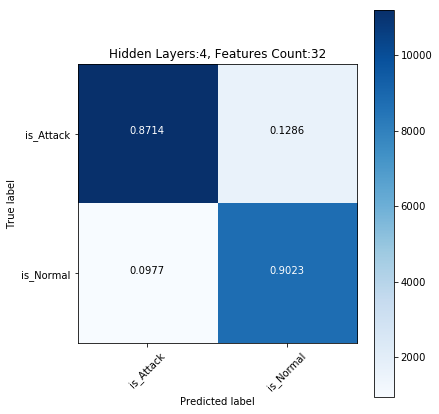

In [23]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)